The VIRAT Video Dataset contained a text file that had descriptions of how the ground truth annotations were stored. The annotations file for each image is a text file with ten numerical columns seperated by whitespaces. 

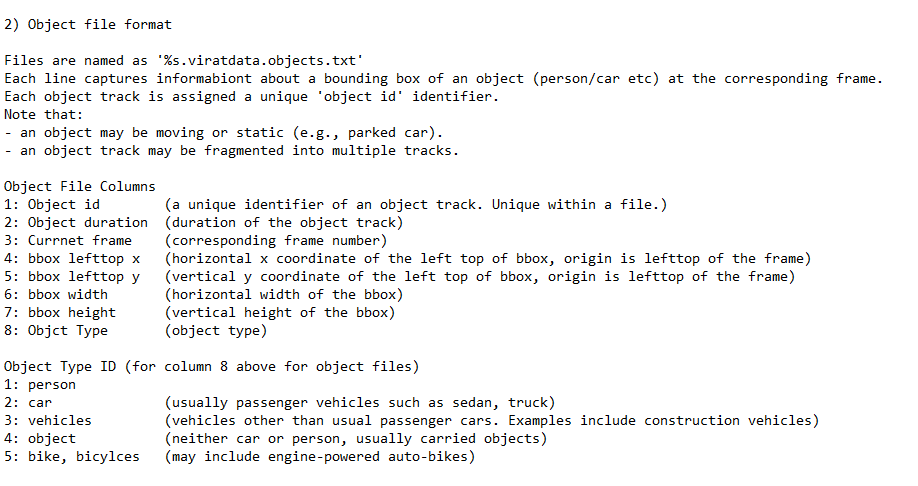

In [1]:
from IPython.display import Image, display
display(Image(filename='object_file_format.png'))

In [2]:
import os
import glob
import pandas as pd
import cv2
import numpy as np

The first thing that I decided to do was use pandas to load an object file for an associated videom with corresponding column names based on the information from the object file format description referenced in the image above

In [3]:
file_path = os.path.join(os.getcwd(), "VIRAT_Ground_Dataset/annotations/VIRAT_S_000001.viratdata.objects.txt")
video_path = os.path.join(os.getcwd(), "VIRAT_Ground_Dataset/videos_original/VIRAT_S_000001.mp4")

df = pd.read_csv(file_path, sep=' ',
                 names=['object_id', 'object_duration', 'current_frame', 'bbox_lefttop_x', 'bbox_lefttop_y',
                        'bbox_width', 'bbox_height', 'object_type'])

df.head()

object_id  object_duration  current_frame  bbox_lefttop_x  bbox_lefttop_y  \
0          1              385           3455               1             663   
1          1              385           3456               1             663   
2          1              385           3457               1             663   
3          1              385           3458               1             663   
4          1              385           3459               1             663   

   bbox_width  bbox_height  object_type  
0          76          132            1  
1          76          132            1  
2          76          132            1  
3          76          132            1  
4          76          132            1

In [4]:
df.shape

(219982, 8)

Based from the information established from the dataframe, a lot of the annotations are duplicates that could potentially be useful for training, but for now given the amount of annotations there exist for this one particular video (~219k annotated frames) I decided to first explore the data by extracting sample frames and using OpenCV to label corresponding objects. Another thing to note is that the bounding box data for each object is not normalized, something that which we'll have to infer and do so.

In [5]:
cap = cv2.VideoCapture(video_path)

frame_number = df['current_frame'].iloc[0]
cap.set(cv2.CAP_PROP_POS_FRAMES, frame_number)

success, frame = cap.read()

extracted_frame_name = os.path.basename(video_path).split('.')[0] + '_Frame_' + str(frame_number) + '.png'
if success:
    cv2.imwrite(extracted_frame_name, frame)

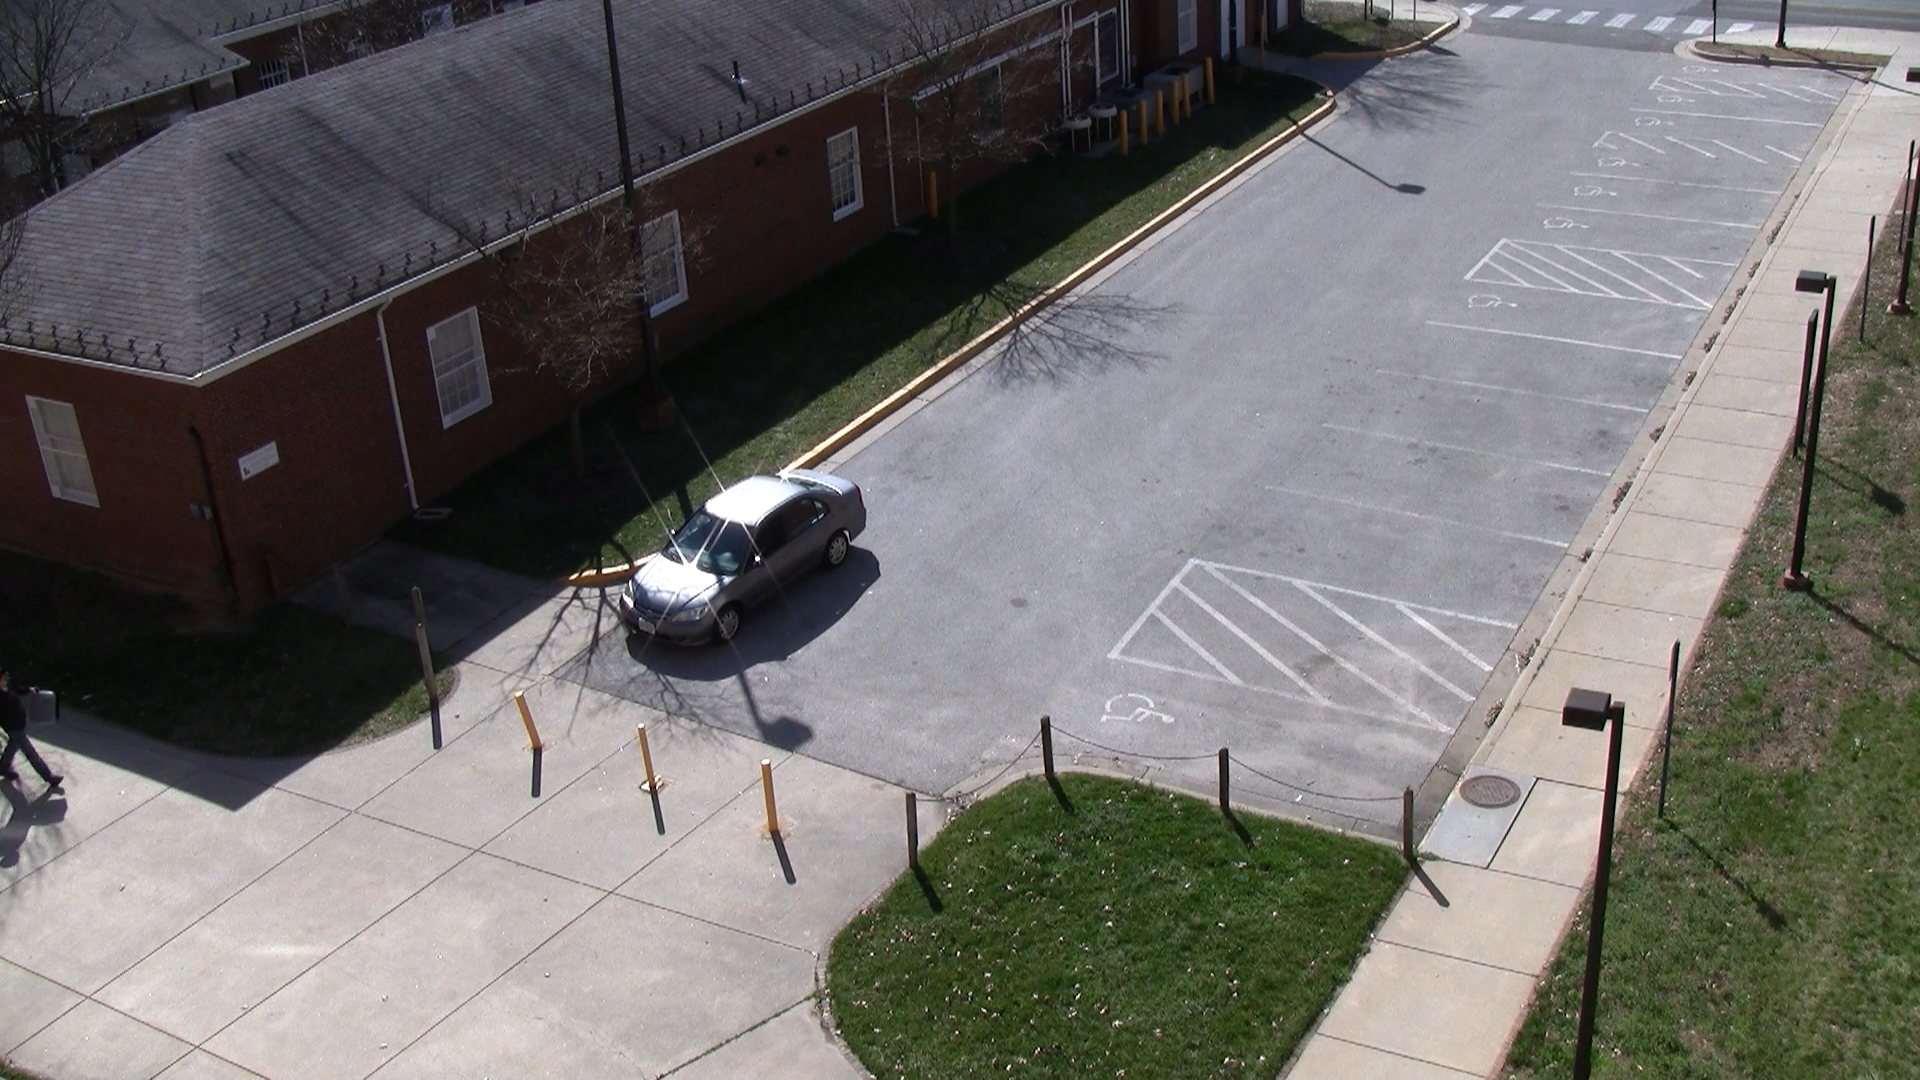

In [6]:
display(Image(filename=extracted_frame_name))

The next step was to view and test out the ground truth annotations given the top x and y bounding box coordinates alongside the box's width and height to infer the other bounding point. The first thing I do is extract all annotations associated with the current frame by taking a subset of the dataframe.

In [7]:
current_frame_df = df[df['current_frame'] == frame_number]
current_frame_df

object_id  object_duration  current_frame  bbox_lefttop_x  \
0               1              385           3455               1   
3840            3             4732           3455             610   
99611          26            20656           3455               6   
120267         27            20656           3455               3   
140923         28            20656           3455             837   
161579         29            20656           3455            1503   
182125         30            20546           3455               6   
202781         31            20656           3455             435   

        bbox_lefttop_y  bbox_width  bbox_height  object_type  
0                  663          76          132            1  
3840               461         261          198            2  
99611                3        1305          615            0  
120267             561         432          186            0  
140923             771         573          303            0  
161579             153         416          921            0  
182125              18        1911         1056            0  
202781              78         897          483            0

We note that there are only two annotations (the person and the car) present since according to the documentation regarding the object annotations, the number zero is an invalid, non-existent annotation type and thus can be excluded. We can test the invalidity of them by creating a bounding box using OpenCV.

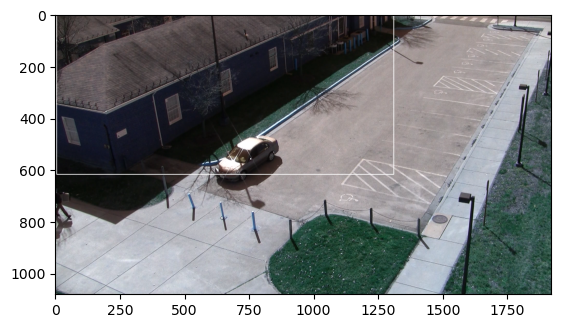

In [8]:
import matplotlib.pyplot as plt

x, y, w, h, _ = current_frame_df[['bbox_lefttop_x', 'bbox_lefttop_y', 'bbox_width', 'bbox_height', 'object_type']].iloc[2].array

img = cv2.imread(extracted_frame_name)

cv2.rectangle(img, (x, y), (x + w, y + h), (255, 255, 255), 2)
plt.imshow(img)

As we see from the labelled image above, the annotations for object type zeros are invalid and need to be removed from our dataset which we can easily do by a simply pandas query.

In [9]:
cleaned_df = df[df['object_type'] != 0]
cleaned_df.head()

object_id  object_duration  current_frame  bbox_lefttop_x  bbox_lefttop_y  \
0          1              385           3455               1             663   
1          1              385           3456               1             663   
2          1              385           3457               1             663   
3          1              385           3458               1             663   
4          1              385           3459               1             663   

   bbox_width  bbox_height  object_type  
0          76          132            1  
1          76          132            1  
2          76          132            1  
3          76          132            1  
4          76          132            1

In [10]:
cleaned_df.shape

(96156, 8)

This also reduces the amount of annotations we have for the video by a significant margin. Now to test out the annotations for the current frame that we had extracted.

In [11]:
current_frame_df = cleaned_df[cleaned_df['current_frame'] == frame_number][['bbox_lefttop_x', 'bbox_lefttop_y', 'bbox_width', 'bbox_height', 'object_type']]
current_frame_df

bbox_lefttop_x  bbox_lefttop_y  bbox_width  bbox_height  object_type
0                  1             663          76          132            1
3840             610             461         261          198            2

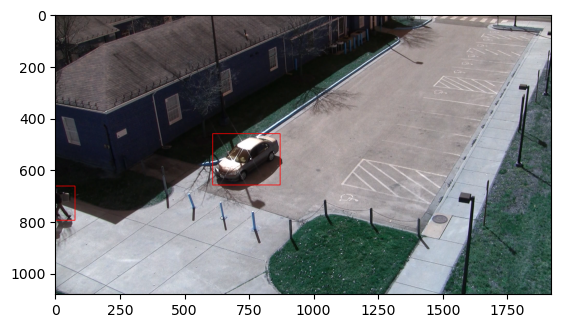

In [12]:
x1 = current_frame_df['bbox_lefttop_x'].to_numpy()
y1 = current_frame_df['bbox_lefttop_y'].to_numpy()
x2 = (current_frame_df['bbox_lefttop_x'] + current_frame_df['bbox_width']).to_numpy()
y2 = (current_frame_df['bbox_lefttop_y'] + current_frame_df['bbox_height']).to_numpy()

img = cv2.imread(extracted_frame_name)

cv2.rectangle(img, (x1[0], y1[0]), (x2[0], y2[0]), (255, 0, 0), 2)
cv2.rectangle(img, (x1[1], y1[1]), (x2[1], y2[1]), (255, 0, 0), 2)

plt.imshow(img)

The next thing to do is to clean our data by filtering for valid object type annotations. After that we need to design an algorithm that extracts all frames per object annotation file as well as creating a new annotation file per frame that contains normalized bounding box coordinates per the YOLO format. 

**Step 1)** Clean up the dataframe again by reducing all possible cases of object type outliers

In [13]:
cleaned_df = df[(df['object_type'] > 0) & (df['object_type'] < 6)]
cleaned_df.head()

object_id  object_duration  current_frame  bbox_lefttop_x  bbox_lefttop_y  \
0          1              385           3455               1             663   
1          1              385           3456               1             663   
2          1              385           3457               1             663   
3          1              385           3458               1             663   
4          1              385           3459               1             663   

   bbox_width  bbox_height  object_type  
0          76          132            1  
1          76          132            1  
2          76          132            1  
3          76          132            1  
4          76          132            1

In [14]:
cleaned_df.shape

(96156, 8)

**Step 2)** Devise an algorithm that will extract all associated frames per video as well as create an associated annotation file (YOLO format) per video frame

   **Step 2.1)** The first thing to do is test out the process of just extracting one frame from a video which we have already done previously and to create an associated YOLO annotation file. 
   
   YOLO annotation files are in the following 5 column **(class_id, x_centre, y_centre, width, height)** white-space delimited format as shown below:

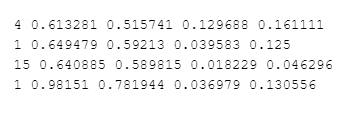

In [15]:
display(Image(filename='YOLO_Example_Format.png'))

Note that each of the bounding box information values are normalized!

We create and test a YOLO format annotation file for the test frame that we had extracted earlier

In [16]:
x_centres = ((x1 + x2) / 2) / img.shape[0]
y_centres = ((y1 + y2) / 2) / img.shape[1]

print("x centre points: ", str(x_centres), "\ny centre points: ", str(y_centres))

x centre points:  [0.03611111 0.68564815] 
y centre points:  [0.3796875  0.29166667]


In [17]:
width_norm = current_frame_df['bbox_width'].to_numpy() / img.shape[0]
height_norm = current_frame_df['bbox_height'].to_numpy() / img.shape[1]

print("Normalized Bounding Box Widths: ", str(width_norm), "\nNormalized Bounding Box Heights: ", str(height_norm))

Normalized Bounding Box Widths:  [0.07037037 0.24166667] 
Normalized Bounding Box Heights:  [0.06875  0.103125]


Let's save this data alongside the object type (class_id) in a text file using pandas

In [18]:
test_data = {
    'class_id': current_frame_df['object_type'].to_numpy(),
    'x_centres': x_centres,
    'y_centres': y_centres,
    'width': width_norm,
    'height': height_norm
}

test_annotation_df = pd.DataFrame(data=test_data)
test_annotation_df

class_id  x_centres  y_centres     width    height
0         1   0.036111   0.379688  0.070370  0.068750
1         2   0.685648   0.291667  0.241667  0.103125

In [19]:
out_path = extracted_frame_name.split('.')[0] + '.txt'
test_annotation_df.to_csv(out_path, sep=' ', header=None, index=None)

In [20]:
with open(out_path, 'r') as text:
    textfile = text.read()
    print(textfile)

1 0.03611111111111111 0.3796875 0.07037037037037037 0.06875
2 0.6856481481481481 0.2916666666666667 0.24166666666666667 0.103125



And as we see, creating the annotation file was a success! What we also want to do is make sure these values are correct by converting them into the two respective bounding box coordinate pairs and using OpenCV to label the two objects present in the frame.

(**Note:** This is only for the means of testing the annotation data that we have as the YOLOv7 model only requires the annotations to be in this format)

In [21]:
with open(out_path, 'r') as text:
    data = text.readlines()
    text.close()

rows = []
dw, dh = img.shape[:2]
    
for dt in data:
    class_id, x, y, w, h = map(float, dt.split(' '))
    
    x1 = int((x - w / 2) * dw)
    x2 = int((x + w / 2) * dw)
    y1 = int((y - h / 2) * dh)
    y2 = int((y + h / 2) * dh)
    
    if x1 < 0:
        x1 = 0
    if x2 > dw - 1:
        x2 = dw - 1
    if y1 < 0:
        y1 = 0
    if y2 > dh - 1:
        y2 = dh - 1
        
    row = (os.path.basename(extracted_frame_name), int(class_id), x1, y1, x2, y2, dw, dh)
    rows.append(row)

col_labels = ['Image', 'Class_Id', 'xMin', 'yMin', 'xMax', 'yMax', 'Width', 'Height']
test_df = pd.DataFrame(rows, columns=col_labels)
test_df

Image  Class_Id  xMin  yMin  xMax  yMax  Width  \
0  VIRAT_S_000001_Frame_3455.png         1     0   663    77   795   1080   
1  VIRAT_S_000001_Frame_3455.png         2   610   461   871   659   1080   

   Height  
0    1920  
1    1920

im = cv2.imread(test_df['Image'].iloc[0])
cv2.rectangle(im, (test_df['xMin'].iloc[0], test_df['yMin'].iloc[0]), (test_df['xMax'].iloc[0], test_df['yMax'].iloc[0]), (255, 0, 0), 2)
cv2.rectangle(im, (test_df['xMin'].iloc[1], test_df['yMin'].iloc[1]), (test_df['xMax'].iloc[1], test_df['yMax'].iloc[1]), (255, 0, 0), 2)
plt.imshow(im)

Our normalizied data was correct! 

**Step 2.2)** We now move onto testing out frame extraction and annotation file creation for a small test batch (5-10 frames) on one video

In [22]:
def extract_frames(videos, object_data_file_path, output_folder, test_extraction):
    for video in videos:
        cap = cv2.VideoCapture(video)
        
        base_file_name = os.path.basename(video).split('.')[0]
        
        obj_data_file = object_data_file_path + base_file_name + '.viratdata.objects.txt'
        df = pd.read_csv(obj_data_file, sep=' ',
                 names=['object_id', 'object_duration', 'current_frame', 'bbox_lefttop_x', 'bbox_lefttop_y',
                        'bbox_width', 'bbox_height', 'object_type'])
        
        cleaned_df = df[(df['object_type'] > 0) & (df['object_type'] < 6)]
        
        grouped = cleaned_df.groupby('current_frame')
        
        i = 0
        for frame_num, group in grouped:
            cap.set(cv2.CAP_PROP_POS_FRAMES, frame_num)
            success, frame = cap.read()

            extracted_frame_name = output_folder + base_file_name + '_Frame_' + str(frame_num) + '.png'
            if success:
                cv2.imwrite(extracted_frame_name, frame)
                
            img = cv2.imread(extracted_frame_name)
            
            x1 = group['bbox_lefttop_x'].to_numpy()
            y1 = group['bbox_lefttop_y'].to_numpy()
            x2 = (group['bbox_lefttop_x'] + group['bbox_width']).to_numpy()
            y2 = (group['bbox_lefttop_y'] + group['bbox_height']).to_numpy()
            
            x_centres = ((x1 + x2) / 2) / img.shape[0]
            y_centres = ((y1 + y2) / 2) / img.shape[1]
            
            width_norm = group['bbox_width'].to_numpy() / img.shape[0]
            height_norm = group['bbox_height'].to_numpy() / img.shape[1]
            
            data = {
                'class_id': group['object_type'].to_numpy(),
                'x_centres': x_centres,
                'y_centres': y_centres,
                'width': width_norm,
                'height': height_norm
            }

            annotation_df = pd.DataFrame(data=data)
            
            out_path = extracted_frame_name.split('.')[0] + '.txt'
            annotation_df.to_csv(out_path, sep=' ', header=None, index=None)
            
            if i == 5:
                break
                
            i += 1
            
        
        if test_extraction:
            break

In [23]:
videos = glob.glob('VIRAT_Ground_Dataset/videos_original' + '/*.mp4')
object_data_file_path = 'VIRAT_Ground_Dataset/annotations/'
output_folder = 'extracted_test_frames/'

extract_frames(videos, object_data_file_path, output_folder, True)

In [24]:
os.listdir('extracted_test_frames/')

['VIRAT_S_000001_Frame_0.png',
 'VIRAT_S_000001_Frame_0.txt',
 'VIRAT_S_000001_Frame_1.png',
 'VIRAT_S_000001_Frame_1.txt',
 'VIRAT_S_000001_Frame_2.png',
 'VIRAT_S_000001_Frame_2.txt',
 'VIRAT_S_000001_Frame_3.png',
 'VIRAT_S_000001_Frame_3.txt',
 'VIRAT_S_000001_Frame_4.png',
 'VIRAT_S_000001_Frame_4.txt',
 'VIRAT_S_000001_Frame_5.png',
 'VIRAT_S_000001_Frame_5.txt']

As we see above, there were a total of five frames extracted with each frame having a corresponding ground truth annotations file. Another thing to note is the quantity of the video frames that we will be collecting Since the total collection is estimated to be about more than 1M+ frames, it is ineffcient to store all the data locally. Therefore a cloud storage system is utilized (Google Drive in this instance). The idea is to upload the frames and their annotation files in batches of roughly 20k files (Images + Annotations) and delete the files locally after each upload call, repeating the process as needed.

In [25]:
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive

gauth = GoogleAuth()           
drive = GoogleDrive(gauth) 

In [26]:
import config

gfile = drive.CreateFile({'parents': [{'id': config.frames_folder}]})
# Read file and set it as the content of this instance.
gfile.SetContentFile('VIRAT_S_000001_Frame_3455.png')
gfile.Upload() # Upload the file.

Your browser has been opened to visit:

    https://accounts.google.com/o/oauth2/auth?client_id=165006644639-q4krasssifld55cgdq1ludhr8eojd16h.apps.googleusercontent.com&redirect_uri=http%3A%2F%2Flocalhost%3A8080%2F&scope=https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive&access_type=offline&response_type=code

Authentication successful.


In [27]:
query = f"'{config.frames_folder}' in parents and trashed=false"
file_list = drive.ListFile({'q': query}).GetList()

for file in file_list:
    print(file['title'])

VIRAT_S_000001_Frame_3455.png


Now that we have tested that the process works for one file, we now proceed to test it for the five frames that we extracted earlier.

In [28]:
files = os.listdir('extracted_test_frames/')

for file in files:
    path = os.path.join('extracted_test_frames', file)
    gfile = drive.CreateFile({'title': file, 'parents': [{'id': config.frames_folder}]})
    # Read file and set it as the content of this instance.
    gfile.SetContentFile(path)
    gfile.Upload() # Upload the file.
    gfile.content.close()

Testing the uploads worked

In [29]:
query = f"'{config.frames_folder}' in parents and trashed=false"
file_list = drive.ListFile({'q': query}).GetList()

for file in file_list:
    print(file['title'])

VIRAT_S_000001_Frame_5.txt
VIRAT_S_000001_Frame_5.png
VIRAT_S_000001_Frame_4.txt
VIRAT_S_000001_Frame_4.png
VIRAT_S_000001_Frame_3.txt
VIRAT_S_000001_Frame_3.png
VIRAT_S_000001_Frame_2.txt
VIRAT_S_000001_Frame_2.png
VIRAT_S_000001_Frame_1.txt
VIRAT_S_000001_Frame_1.png
VIRAT_S_000001_Frame_0.txt
VIRAT_S_000001_Frame_0.png
VIRAT_S_000001_Frame_3455.png


Now deleting the local instances of the files

In [30]:
import time

for file in files:
    path = os.path.join('extracted_test_frames', file)
    
    try:        
        os.remove(path)
        print(f"Deleted: {file}")
    except OSError as e:
        print(f"Failed to delete: {file} ({e})")

# Check the contents of the folder after deletion
updated_files = os.listdir('extracted_test_frames/')
print(f"Remaining files: {updated_files}")

Deleted: VIRAT_S_000001_Frame_0.png
Deleted: VIRAT_S_000001_Frame_0.txt
Deleted: VIRAT_S_000001_Frame_1.png
Deleted: VIRAT_S_000001_Frame_1.txt
Deleted: VIRAT_S_000001_Frame_2.png
Deleted: VIRAT_S_000001_Frame_2.txt
Deleted: VIRAT_S_000001_Frame_3.png
Deleted: VIRAT_S_000001_Frame_3.txt
Deleted: VIRAT_S_000001_Frame_4.png
Deleted: VIRAT_S_000001_Frame_4.txt
Deleted: VIRAT_S_000001_Frame_5.png
Deleted: VIRAT_S_000001_Frame_5.txt
Remaining files: []


Now to implement this process in our function and testing it for only 10 frames.

In [31]:
def extract_frames(videos, object_data_file_path, output_folder, test_extraction):
    for video in videos:
        cap = cv2.VideoCapture(video)
        
        base_file_name = os.path.basename(video).split('.')[0]
        
        obj_data_file = object_data_file_path + base_file_name + '.viratdata.objects.txt'
        df = pd.read_csv(obj_data_file, sep=' ',
                 names=['object_id', 'object_duration', 'current_frame', 'bbox_lefttop_x', 'bbox_lefttop_y',
                        'bbox_width', 'bbox_height', 'object_type'])
        
        cleaned_df = df[(df['object_type'] > 0) & (df['object_type'] < 6)]
        
        grouped = cleaned_df.groupby('current_frame')
        
        i = 0
        for frame_num, group in grouped:
            cap.set(cv2.CAP_PROP_POS_FRAMES, frame_num)
            success, frame = cap.read()

            extracted_frame_name = output_folder + base_file_name + '_Frame_' + str(frame_num) + '.png'
            if success:
                cv2.imwrite(extracted_frame_name, frame)
                
            img = cv2.imread(extracted_frame_name)
            
            x1 = group['bbox_lefttop_x'].to_numpy()
            y1 = group['bbox_lefttop_y'].to_numpy()
            x2 = (group['bbox_lefttop_x'] + group['bbox_width']).to_numpy()
            y2 = (group['bbox_lefttop_y'] + group['bbox_height']).to_numpy()
            
            x_centres = ((x1 + x2) / 2) / img.shape[0]
            y_centres = ((y1 + y2) / 2) / img.shape[1]
            
            width_norm = group['bbox_width'].to_numpy() / img.shape[0]
            height_norm = group['bbox_height'].to_numpy() / img.shape[1]
            
            data = {
                'class_id': group['object_type'].to_numpy(),
                'x_centres': x_centres,
                'y_centres': y_centres,
                'width': width_norm,
                'height': height_norm
            }

            annotation_df = pd.DataFrame(data=data)
            
            out_path = extracted_frame_name.split('.')[0] + '.txt'
            annotation_df.to_csv(out_path, sep=' ', header=None, index=None)
            
            if (i != 0) & (i % 10 == 0):
                for file in os.listdir(output_folder)[1:]:
                    gfile = drive.CreateFile({'title': file, 'parents': [{'id': config.frames_folder}]})
                    # Read file and set it as the content of this instance.
                    gfile.SetContentFile(os.path.join(output_folder, file))
                    gfile.Upload() # Upload the file.
                    gfile.content.close()
                    
                for file in os.listdir(output_folder)[1:]:
                    path = os.path.join(output_folder, file)

                    try:        
                        os.remove(path)
                        print(f"Deleted: {file}")
                    except OSError as e:
                        print(f"Failed to delete: {file} ({e})")
                        
                if (i == 10) & (test_extraction):
                    break
                    
            i += 1
            
        
        if test_extraction:
            break

In [32]:
extract_frames(videos, object_data_file_path, output_folder, True)

Deleted: VIRAT_S_000001_Frame_0.txt
Deleted: VIRAT_S_000001_Frame_1.png
Deleted: VIRAT_S_000001_Frame_1.txt
Deleted: VIRAT_S_000001_Frame_10.png
Deleted: VIRAT_S_000001_Frame_10.txt
Deleted: VIRAT_S_000001_Frame_2.png
Deleted: VIRAT_S_000001_Frame_2.txt
Deleted: VIRAT_S_000001_Frame_3.png
Deleted: VIRAT_S_000001_Frame_3.txt
Deleted: VIRAT_S_000001_Frame_4.png
Deleted: VIRAT_S_000001_Frame_4.txt
Deleted: VIRAT_S_000001_Frame_5.png
Deleted: VIRAT_S_000001_Frame_5.txt
Deleted: VIRAT_S_000001_Frame_6.png
Deleted: VIRAT_S_000001_Frame_6.txt
Deleted: VIRAT_S_000001_Frame_7.png
Deleted: VIRAT_S_000001_Frame_7.txt
Deleted: VIRAT_S_000001_Frame_8.png
Deleted: VIRAT_S_000001_Frame_8.txt
Deleted: VIRAT_S_000001_Frame_9.png
Deleted: VIRAT_S_000001_Frame_9.txt


In [33]:
os.listdir(output_folder)[1:]

[]